In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1_normalized_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 184)
(734160, 1)
validation
(101248, 184)
(101248, 1)
test
(100432, 184)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 184)]             0         


 dense (Dense)               (None, 1024)              189440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 878593 (3.35 MB)


Trainable params: 878593 (3.35 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:43 - loss: 0.0102 - STD: 8.9820e-05 - MAE: 0.0839

 6/74 [=>............................] - ETA: 0s - loss: 0.0120 - STD: 8.9921e-05 - MAE: 0.0867  

11/74 [===>..........................] - ETA: 0s - loss: 0.0112 - STD: 9.8480e-05 - MAE: 0.0814

16/74 [=====>........................] - ETA: 0s - loss: 0.0107 - STD: 1.2149e-04 - MAE: 0.0809

21/74 [=======>......................] - ETA: 0s - loss: 0.0104 - STD: 1.3918e-04 - MAE: 0.0795

26/74 [=========>....................] - ETA: 0s - loss: 0.0102 - STD: 1.6200e-04 - MAE: 0.0790

31/74 [===========>..................] - ETA: 0s - loss: 0.0101 - STD: 1.8338e-04 - MAE: 0.0784

36/74 [=============>................] - ETA: 0s - loss: 0.0100 - STD: 2.0657e-04 - MAE: 0.0779

41/74 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 2.3211e-04 - MAE: 0.0776

46/74 [=================>............] - ETA: 0s - loss: 0.0098 - STD: 2.5874e-04 - MAE: 0.0774

51/74 [===================>..........] - ETA: 0s - loss: 0.0097 - STD: 2.8929e-04 - MAE: 0.0772

56/74 [=====================>........] - ETA: 0s - loss: 0.0097 - STD: 3.2261e-04 - MAE: 0.0770

61/74 [=======================>......] - ETA: 0s - loss: 0.0097 - STD: 3.6120e-04 - MAE: 0.0769

66/74 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 4.0491e-04 - MAE: 0.0768

68/74 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 4.2471e-04 - MAE: 0.0767

73/74 [============================>.] - ETA: 0s - loss: 0.0096 - STD: 4.7989e-04 - MAE: 0.0766

74/74 [==============================] - 4s 30ms/step - loss: 0.0096 - STD: 4.9214e-04 - MAE: 0.0766 - val_loss: 0.0085 - val_STD: 0.0012 - val_MAE: 0.0713


Epoch 2/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0093 - STD: 0.0014 - MAE: 0.0757

 6/74 [=>............................] - ETA: 0s - loss: 0.0092 - STD: 0.0016 - MAE: 0.0755

11/74 [===>..........................] - ETA: 0s - loss: 0.0092 - STD: 0.0018 - MAE: 0.0752

16/74 [=====>........................] - ETA: 0s - loss: 0.0091 - STD: 0.0021 - MAE: 0.0751

21/74 [=======>......................] - ETA: 0s - loss: 0.0091 - STD: 0.0024 - MAE: 0.0749

26/74 [=========>....................] - ETA: 0s - loss: 0.0091 - STD: 0.0028 - MAE: 0.0749

31/74 [===========>..................] - ETA: 0s - loss: 0.0090 - STD: 0.0034 - MAE: 0.0748

36/74 [=============>................] - ETA: 0s - loss: 0.0090 - STD: 0.0041 - MAE: 0.0746

41/74 [===============>..............] - ETA: 0s - loss: 0.0089 - STD: 0.0052 - MAE: 0.0745

46/74 [=================>............] - ETA: 0s - loss: 0.0089 - STD: 0.0064 - MAE: 0.0742

51/74 [===================>..........] - ETA: 0s - loss: 0.0088 - STD: 0.0081 - MAE: 0.0739

56/74 [=====================>........] - ETA: 0s - loss: 0.0087 - STD: 0.0099 - MAE: 0.0737

61/74 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0118 - MAE: 0.0733

66/74 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.0136 - MAE: 0.0730

71/74 [===========================>..] - ETA: 0s - loss: 0.0085 - STD: 0.0153 - MAE: 0.0726

74/74 [==============================] - 1s 13ms/step - loss: 0.0084 - STD: 0.0162 - MAE: 0.0724 - val_loss: 0.0065 - val_STD: 0.0287 - val_MAE: 0.0623


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0071 - STD: 0.0404 - MAE: 0.0677

 6/74 [=>............................] - ETA: 0s - loss: 0.0071 - STD: 0.0401 - MAE: 0.0659

11/74 [===>..........................] - ETA: 0s - loss: 0.0070 - STD: 0.0409 - MAE: 0.0653

16/74 [=====>........................] - ETA: 0s - loss: 0.0069 - STD: 0.0420 - MAE: 0.0649

21/74 [=======>......................] - ETA: 0s - loss: 0.0069 - STD: 0.0431 - MAE: 0.0647

26/74 [=========>....................] - ETA: 0s - loss: 0.0069 - STD: 0.0443 - MAE: 0.0645

31/74 [===========>..................] - ETA: 0s - loss: 0.0069 - STD: 0.0452 - MAE: 0.0643

36/74 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0459 - MAE: 0.0639

41/74 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.0466 - MAE: 0.0637

46/74 [=================>............] - ETA: 0s - loss: 0.0067 - STD: 0.0471 - MAE: 0.0636

51/74 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0476 - MAE: 0.0634

56/74 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0480 - MAE: 0.0632

61/74 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0484 - MAE: 0.0631

66/74 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0486 - MAE: 0.0630

71/74 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0489 - MAE: 0.0630

74/74 [==============================] - 1s 13ms/step - loss: 0.0066 - STD: 0.0490 - MAE: 0.0629 - val_loss: 0.0058 - val_STD: 0.0378 - val_MAE: 0.0580


Epoch 4/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0516 - MAE: 0.0615

 6/74 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0513 - MAE: 0.0607

11/74 [===>..........................] - ETA: 0s - loss: 0.0063 - STD: 0.0520 - MAE: 0.0610

16/74 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0523 - MAE: 0.0608

21/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0528 - MAE: 0.0609

26/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0530 - MAE: 0.0609

31/74 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0532 - MAE: 0.0609

36/74 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0533 - MAE: 0.0608

41/74 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0534 - MAE: 0.0608

46/74 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0535 - MAE: 0.0607

51/74 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0537 - MAE: 0.0607

56/74 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0538 - MAE: 0.0606

61/74 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0540 - MAE: 0.0606

66/74 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0541 - MAE: 0.0605

71/74 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0542 - MAE: 0.0605

74/74 [==============================] - 1s 13ms/step - loss: 0.0062 - STD: 0.0542 - MAE: 0.0604 - val_loss: 0.0056 - val_STD: 0.0411 - val_MAE: 0.0568


Epoch 5/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0603

 6/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0598

11/74 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0598

16/74 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0564 - MAE: 0.0598

21/74 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0597

26/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0598

31/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0598

36/74 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0597

41/74 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0597

46/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0598

51/74 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0597

56/74 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0597

61/74 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0596

66/74 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0596

71/74 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0596

74/74 [==============================] - 1s 13ms/step - loss: 0.0060 - STD: 0.0563 - MAE: 0.0596 - val_loss: 0.0054 - val_STD: 0.0425 - val_MAE: 0.0558


Epoch 6/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0059 - STD: 0.0577 - MAE: 0.0586

 6/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0577 - MAE: 0.0595

11/74 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0575 - MAE: 0.0594

16/74 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0575 - MAE: 0.0595

21/74 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0573 - MAE: 0.0596

26/74 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0571 - MAE: 0.0595

31/74 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0570 - MAE: 0.0594

36/74 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0594

41/74 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0594

46/74 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0594

51/74 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0593

56/74 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0593

61/74 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0593

66/74 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0592

71/74 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0592

74/74 [==============================] - 1s 13ms/step - loss: 0.0059 - STD: 0.0569 - MAE: 0.0592 - val_loss: 0.0054 - val_STD: 0.0445 - val_MAE: 0.0569


Epoch 7/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0593 - MAE: 0.0606

 6/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0588

11/74 [===>..........................] - ETA: 0s - loss: 0.0059 - STD: 0.0576 - MAE: 0.0591

16/74 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0591

21/74 [=======>......................] - ETA: 0s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0590

26/74 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0590

31/74 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0589

36/74 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0589

41/74 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0589

46/74 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0589

51/74 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0589

56/74 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0589

61/74 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0589

66/74 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0588

71/74 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0588

74/74 [==============================] - 1s 13ms/step - loss: 0.0059 - STD: 0.0575 - MAE: 0.0588 - val_loss: 0.0053 - val_STD: 0.0441 - val_MAE: 0.0549


Epoch 8/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0589 - MAE: 0.0595

 6/74 [=>............................] - ETA: 0s - loss: 0.0059 - STD: 0.0576 - MAE: 0.0589

11/74 [===>..........................] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0589

16/74 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0588

21/74 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0586

26/74 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0586

31/74 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0585

36/74 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0585

41/74 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0585

46/74 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0585

51/74 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0585

56/74 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0585

61/74 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0586

66/74 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0586

71/74 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0586

74/74 [==============================] - 1s 13ms/step - loss: 0.0058 - STD: 0.0579 - MAE: 0.0586 - val_loss: 0.0057 - val_STD: 0.0404 - val_MAE: 0.0543


Epoch 9/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0526 - MAE: 0.0574

 6/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0565 - MAE: 0.0584

11/74 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0567 - MAE: 0.0586

16/74 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0567 - MAE: 0.0586

21/74 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0569 - MAE: 0.0584

26/74 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0584

31/74 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0584

36/74 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0584

41/74 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0583

46/74 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0583

51/74 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0583

56/74 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0583

61/74 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0583

66/74 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0583

71/74 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0584

74/74 [==============================] - 1s 13ms/step - loss: 0.0058 - STD: 0.0581 - MAE: 0.0584 - val_loss: 0.0060 - val_STD: 0.0399 - val_MAE: 0.0548


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0516 - MAE: 0.0572

 6/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0567 - MAE: 0.0593

11/74 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0555 - MAE: 0.0593

16/74 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0550 - MAE: 0.0606

21/74 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0605

26/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0607

31/74 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0531 - MAE: 0.0604

36/74 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0530 - MAE: 0.0602

41/74 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0535 - MAE: 0.0601

46/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0539 - MAE: 0.0599

51/74 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0544 - MAE: 0.0598

56/74 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0547 - MAE: 0.0596

61/74 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0551 - MAE: 0.0595

66/74 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0554 - MAE: 0.0594

71/74 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0557 - MAE: 0.0593

74/74 [==============================] - 1s 13ms/step - loss: 0.0059 - STD: 0.0558 - MAE: 0.0592 - val_loss: 0.0052 - val_STD: 0.0464 - val_MAE: 0.0542


Epoch 11/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0605 - MAE: 0.0580

 6/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0598 - MAE: 0.0579

11/74 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0596 - MAE: 0.0580

16/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0595 - MAE: 0.0580

21/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0579

26/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0579

31/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0579

36/74 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0579

41/74 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0579

46/74 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0579

51/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0579

56/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0579

61/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0578

66/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0578

71/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0578

74/74 [==============================] - 1s 13ms/step - loss: 0.0057 - STD: 0.0593 - MAE: 0.0578 - val_loss: 0.0052 - val_STD: 0.0461 - val_MAE: 0.0539


Epoch 12/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0058 - STD: 0.0598 - MAE: 0.0583

 6/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0578

11/74 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0598 - MAE: 0.0578

16/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0598 - MAE: 0.0579

21/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0594 - MAE: 0.0578

26/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0579

31/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0580

36/74 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0579

41/74 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0579

46/74 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0579

51/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0579

56/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0580

61/74 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0588 - MAE: 0.0583

66/74 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0583 - MAE: 0.0584

71/74 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0585

74/74 [==============================] - 1s 13ms/step - loss: 0.0058 - STD: 0.0576 - MAE: 0.0585 - val_loss: 0.0053 - val_STD: 0.0406 - val_MAE: 0.0541


Epoch 13/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0520 - MAE: 0.0576

 6/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0541 - MAE: 0.0590

11/74 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0550 - MAE: 0.0585

16/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0563 - MAE: 0.0581

21/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0573 - MAE: 0.0580

26/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0579

31/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0578

36/74 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0578

41/74 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0578

46/74 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0577

51/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0577

56/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0577

61/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0577

66/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0577

71/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0577

74/74 [==============================] - 1s 12ms/step - loss: 0.0057 - STD: 0.0590 - MAE: 0.0577 - val_loss: 0.0053 - val_STD: 0.0460 - val_MAE: 0.0534


Epoch 14/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0575 - MAE: 0.0567

 6/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0576

11/74 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0575

16/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0575

21/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0574

26/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0575

31/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0575

36/74 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0575

41/74 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0575

46/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0575

51/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0574

56/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0574

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0574

66/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0574

71/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0574

74/74 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0596 - MAE: 0.0574 - val_loss: 0.0051 - val_STD: 0.0485 - val_MAE: 0.0537


Epoch 15/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0572

 6/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0603 - MAE: 0.0575

11/74 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0604 - MAE: 0.0576

16/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0604 - MAE: 0.0574

21/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0604 - MAE: 0.0574

26/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0573

31/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0573

36/74 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0573

41/74 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0572

46/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0573

51/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0573

56/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0573

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0574

66/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0574

71/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0574

74/74 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0594 - MAE: 0.0575 - val_loss: 0.0055 - val_STD: 0.0440 - val_MAE: 0.0533


Epoch 16/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0537 - MAE: 0.0567

 6/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0574 - MAE: 0.0579

11/74 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0575 - MAE: 0.0578

16/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0580

21/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0580

26/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0578

31/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0578

36/74 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0576

41/74 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0576

46/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0576

51/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0575

56/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0575

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0575

66/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0574

71/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0574

74/74 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0593 - MAE: 0.0574 - val_loss: 0.0051 - val_STD: 0.0505 - val_MAE: 0.0536


Epoch 17/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0571

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0568

11/74 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0570

16/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0604 - MAE: 0.0571

21/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0570

26/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0570

31/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0570

36/74 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0570

41/74 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0571

46/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0571

51/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0574

56/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0576

61/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0577

66/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0577

71/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0576

74/74 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0590 - MAE: 0.0576 - val_loss: 0.0051 - val_STD: 0.0523 - val_MAE: 0.0537


Epoch 18/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0622 - MAE: 0.0574

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0567

11/74 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0567

16/74 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0569

21/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0569

26/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0568

31/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0568

36/74 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568

41/74 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568

46/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568

51/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568

56/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568

61/74 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0568

71/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568

74/74 [==============================] - 1s 12ms/step - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569 - val_loss: 0.0052 - val_STD: 0.0505 - val_MAE: 0.0532


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0585 - MAE: 0.0564

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0567

11/74 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0567

16/74 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0568

21/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0567

26/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0567

31/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0567

35/74 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0567

39/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0567

44/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0567

49/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568

54/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0567

58/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0567

63/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0567

68/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0567

73/74 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0568

74/74 [==============================] - 1s 13ms/step - loss: 0.0055 - STD: 0.0607 - MAE: 0.0568 - val_loss: 0.0052 - val_STD: 0.0511 - val_MAE: 0.0532


Epoch 20/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0588 - MAE: 0.0562

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0567

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0565

16/74 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0566

21/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0566

26/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0566

31/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0566

36/74 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0567

41/74 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569

46/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0570

51/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0572

56/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0572

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0572

66/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0572

71/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0571

74/74 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0598 - MAE: 0.0572 - val_loss: 0.0050 - val_STD: 0.0530 - val_MAE: 0.0534


Epoch 21/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0568

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0567

11/74 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0566

16/74 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0566

21/74 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0566

26/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0566

31/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0613 - MAE: 0.0566

36/74 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0567

41/74 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0567

46/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0567

51/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0567

56/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0567

61/74 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0567

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0568

71/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0569

74/74 [==============================] - 1s 13ms/step - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569 - val_loss: 0.0051 - val_STD: 0.0550 - val_MAE: 0.0561


Epoch 22/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0621 - MAE: 0.0603

 6/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0576

11/74 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0576

16/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0573

21/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0572

26/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0571

31/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0572

36/74 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0571

41/74 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0571

46/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0570

51/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569

56/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569

61/74 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0569

71/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0569

74/74 [==============================] - 1s 13ms/step - loss: 0.0055 - STD: 0.0606 - MAE: 0.0568 - val_loss: 0.0050 - val_STD: 0.0533 - val_MAE: 0.0533


Epoch 23/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0565

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0563

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0563

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0564

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0565

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0566

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0566

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0565

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0566

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0565

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0566

56/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0566

71/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0566

74/74 [==============================] - 1s 13ms/step - loss: 0.0055 - STD: 0.0612 - MAE: 0.0565 - val_loss: 0.0049 - val_STD: 0.0562 - val_MAE: 0.0546


Epoch 24/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0576

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0564

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0565

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0565

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0565

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0566

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0565

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0565

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0565

56/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0565

60/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0565

65/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0565

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0565

74/74 [==============================] - 1s 13ms/step - loss: 0.0054 - STD: 0.0615 - MAE: 0.0566 - val_loss: 0.0056 - val_STD: 0.0487 - val_MAE: 0.0537


Epoch 25/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0564 - MAE: 0.0558

 6/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0578

11/74 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0582 - MAE: 0.0573

16/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0572

21/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0571

26/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0572

31/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0573

36/74 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0572

41/74 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0572

46/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0572

51/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0572

56/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0572

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0571

66/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0571

71/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0570

74/74 [==============================] - 1s 13ms/step - loss: 0.0055 - STD: 0.0600 - MAE: 0.0570 - val_loss: 0.0051 - val_STD: 0.0529 - val_MAE: 0.0531


Epoch 26/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0603 - MAE: 0.0556

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0567

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0563

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0564

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0563

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0564

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0565

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0565

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0565

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0565

56/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0564

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0564

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0564

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0564

74/74 [==============================] - 1s 13ms/step - loss: 0.0054 - STD: 0.0616 - MAE: 0.0564 - val_loss: 0.0050 - val_STD: 0.0542 - val_MAE: 0.0532


Epoch 27/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0560

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0562

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0562

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0563

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0564

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0565

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0565

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0564

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0564

56/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0564

60/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0564

64/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0564

69/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0563

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0563

74/74 [==============================] - 1s 13ms/step - loss: 0.0054 - STD: 0.0617 - MAE: 0.0563 - val_loss: 0.0051 - val_STD: 0.0530 - val_MAE: 0.0530


Epoch 28/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0603 - MAE: 0.0555

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0566

11/74 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0565

16/74 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0566

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0565

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0565

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0565

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0564

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0564

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0564

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0564

56/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0564

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0564

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0563

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0563

74/74 [==============================] - 1s 13ms/step - loss: 0.0054 - STD: 0.0617 - MAE: 0.0564 - val_loss: 0.0054 - val_STD: 0.0500 - val_MAE: 0.0533


Epoch 29/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0572 - MAE: 0.0561

 6/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0607 - MAE: 0.0573

11/74 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0571

16/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0573

21/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0571

26/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0569

31/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568

36/74 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0567

41/74 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0567

46/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0566

51/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0566

56/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0566

61/74 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0565

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0565

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0564

74/74 [==============================] - 1s 13ms/step - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565 - val_loss: 0.0049 - val_STD: 0.0554 - val_MAE: 0.0537


Epoch 30/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0558

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0615 - MAE: 0.0559

11/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0561

15/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0561

20/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0565

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0564

30/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0564

35/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0565

39/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0564

44/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0564

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0564

54/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0564

59/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0564

64/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0564

69/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563

74/74 [==============================] - 1s 13ms/step - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563 - val_loss: 0.0049 - val_STD: 0.0546 - val_MAE: 0.0533


Epoch 31/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0566

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0562

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0562

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0563

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563

56/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0563

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0564

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

74/74 [==============================] - 1s 14ms/step - loss: 0.0054 - STD: 0.0612 - MAE: 0.0565 - val_loss: 0.0049 - val_STD: 0.0553 - val_MAE: 0.0549


Epoch 32/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0585

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0566

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0564

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0563

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0562

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0562

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0562

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0562

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0562

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0562

56/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0562

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0562

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0562

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0562

74/74 [==============================] - 1s 13ms/step - loss: 0.0054 - STD: 0.0619 - MAE: 0.0562 - val_loss: 0.0049 - val_STD: 0.0551 - val_MAE: 0.0533


Epoch 33/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0633 - MAE: 0.0556

 5/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

10/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0559

15/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0561

20/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0560

24/74 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0561

29/74 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0561

34/74 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0561

39/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0560

44/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0560

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0561

54/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0561

59/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

64/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0561

69/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0561

74/74 [==============================] - 1s 13ms/step - loss: 0.0054 - STD: 0.0620 - MAE: 0.0561 - val_loss: 0.0049 - val_STD: 0.0554 - val_MAE: 0.0535


Epoch 34/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0569

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558

11/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0559

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0561

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

56/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0562

74/74 [==============================] - 1s 14ms/step - loss: 0.0054 - STD: 0.0619 - MAE: 0.0562 - val_loss: 0.0049 - val_STD: 0.0570 - val_MAE: 0.0540


Epoch 35/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0567

 5/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0619 - MAE: 0.0564

10/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

14/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0565

19/74 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0564

24/74 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0563

29/74 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0565

34/74 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0566

39/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0565

44/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0566

49/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0565

54/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0566

58/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0565

63/74 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0565

68/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0565

73/74 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0565

74/74 [==============================] - 1s 13ms/step - loss: 0.0055 - STD: 0.0611 - MAE: 0.0565 - val_loss: 0.0052 - val_STD: 0.0500 - val_MAE: 0.0527


Epoch 36/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0569 - MAE: 0.0553

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0562

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0558

16/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0559

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0560

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0560

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0561

50/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0561

54/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

59/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

64/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

69/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

74/74 [==============================] - 1s 13ms/step - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561 - val_loss: 0.0050 - val_STD: 0.0540 - val_MAE: 0.0530


Epoch 37/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0615 - MAE: 0.0554

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

11/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0560

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0560

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0560

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0560

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0561

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0561

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

56/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0560

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0561

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0561

74/74 [==============================] - 1s 14ms/step - loss: 0.0054 - STD: 0.0622 - MAE: 0.0560 - val_loss: 0.0049 - val_STD: 0.0540 - val_MAE: 0.0532


Epoch 38/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0569

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558

11/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0557

16/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0558

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0560

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0562

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0562

56/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0562

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

74/74 [==============================] - 1s 14ms/step - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562 - val_loss: 0.0049 - val_STD: 0.0556 - val_MAE: 0.0535


Epoch 39/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0634 - MAE: 0.0562

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0566

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0565

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0564

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0564

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0562

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0562

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0561

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

56/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0561

74/74 [==============================] - 1s 13ms/step - loss: 0.0054 - STD: 0.0621 - MAE: 0.0560 - val_loss: 0.0050 - val_STD: 0.0555 - val_MAE: 0.0531


Epoch 40/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0551

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

11/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0554

16/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0557

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

36/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0557

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0557

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0558

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0558

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0558

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0558

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0558

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0558

74/74 [==============================] - 1s 13ms/step - loss: 0.0053 - STD: 0.0626 - MAE: 0.0558 - val_loss: 0.0049 - val_STD: 0.0540 - val_MAE: 0.0529


Epoch 41/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0610 - MAE: 0.0558

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0613 - MAE: 0.0558

11/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

16/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0559

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0558

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0558

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0558

36/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0558

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0559

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0559

74/74 [==============================] - 1s 13ms/step - loss: 0.0053 - STD: 0.0622 - MAE: 0.0559 - val_loss: 0.0050 - val_STD: 0.0547 - val_MAE: 0.0529


Epoch 42/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0557

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0564

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0564

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0562

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0562

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0561

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0560

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0560

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0624 - MAE: 0.0560

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0559

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0559

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0559

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0559

74/74 [==============================] - 1s 13ms/step - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558 - val_loss: 0.0049 - val_STD: 0.0543 - val_MAE: 0.0529


Epoch 43/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0611 - MAE: 0.0555

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0563

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0626 - MAE: 0.0564

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0561

21/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0624 - MAE: 0.0562

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0561

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0560

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0559

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0559

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559

74/74 [==============================] - 1s 14ms/step - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559 - val_loss: 0.0049 - val_STD: 0.0569 - val_MAE: 0.0540


Epoch 44/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0572

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0633 - MAE: 0.0558

11/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0633 - MAE: 0.0558

16/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0558

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0558

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0559

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0558

36/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0559

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0559

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0559

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0559

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0559

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0558

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0558

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0558

74/74 [==============================] - 1s 13ms/step - loss: 0.0053 - STD: 0.0625 - MAE: 0.0558 - val_loss: 0.0049 - val_STD: 0.0576 - val_MAE: 0.0538


Epoch 45/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0568

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0561

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0627 - MAE: 0.0560

16/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

26/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0560

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0560

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0559

41/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0559

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0559

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0559

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0559

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0559

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

74/74 [==============================] - 1s 13ms/step - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558 - val_loss: 0.0049 - val_STD: 0.0553 - val_MAE: 0.0530


Epoch 46/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0555

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0629 - MAE: 0.0560

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0625 - MAE: 0.0563

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0560

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0560

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559

36/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0558

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0558

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0558

74/74 [==============================] - 1s 13ms/step - loss: 0.0053 - STD: 0.0623 - MAE: 0.0558 - val_loss: 0.0051 - val_STD: 0.0528 - val_MAE: 0.0527


Epoch 47/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0053 - STD: 0.0595 - MAE: 0.0551

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0562

10/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0561

15/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0561

20/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560

25/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

30/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0558

35/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0559

40/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

44/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

49/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

54/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557

59/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0558

64/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0557

69/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0557

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0557

74/74 [==============================] - 1s 14ms/step - loss: 0.0053 - STD: 0.0626 - MAE: 0.0557 - val_loss: 0.0049 - val_STD: 0.0554 - val_MAE: 0.0531


Epoch 48/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0556

11/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0556

16/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0557

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0631 - MAE: 0.0557

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0557

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0557

36/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0558

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0558

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0557

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0557

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0557

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0557

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0557

74/74 [==============================] - 1s 13ms/step - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557 - val_loss: 0.0051 - val_STD: 0.0519 - val_MAE: 0.0526


Epoch 49/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0053 - STD: 0.0592 - MAE: 0.0551

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0612 - MAE: 0.0558

11/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0556

16/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0559

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0558

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0558

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0557

35/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557

40/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0557

45/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

50/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556

55/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

60/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0555

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556

74/74 [==============================] - 1s 13ms/step - loss: 0.0053 - STD: 0.0626 - MAE: 0.0556 - val_loss: 0.0053 - val_STD: 0.0516 - val_MAE: 0.0529


Epoch 50/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0587 - MAE: 0.0549

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0628 - MAE: 0.0562

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0560

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0559

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0559

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0558

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0557

36/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0557

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0557

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0556

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556

74/74 [==============================] - 1s 13ms/step - loss: 0.0053 - STD: 0.0627 - MAE: 0.0556 - val_loss: 0.0052 - val_STD: 0.0532 - val_MAE: 0.0528


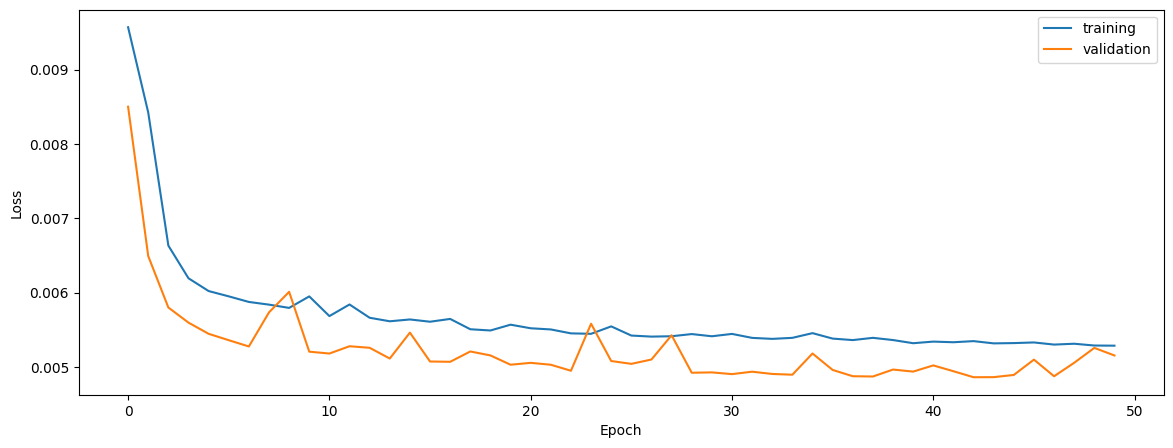

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.6526115158419301
0.6614616453852535
0.6575272572543133


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.6526115158419301
0.6614616453852535
0.6575272572543133


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.6471475044884563
0.6652818662787976
0.6580271372298983


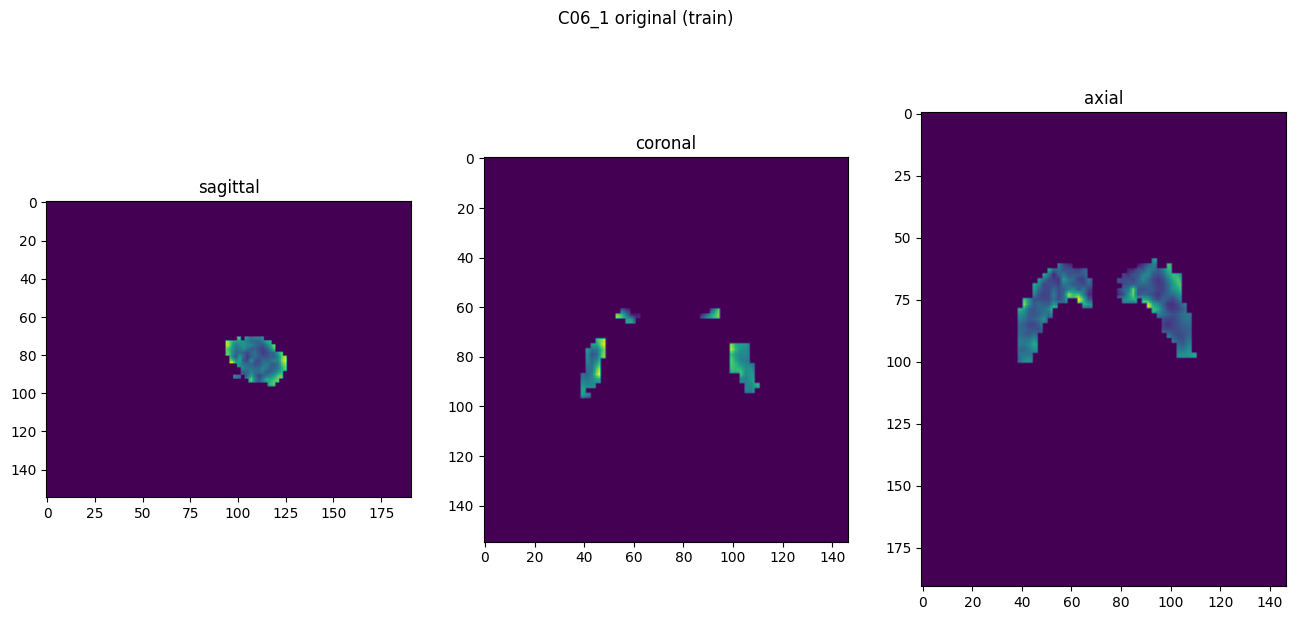

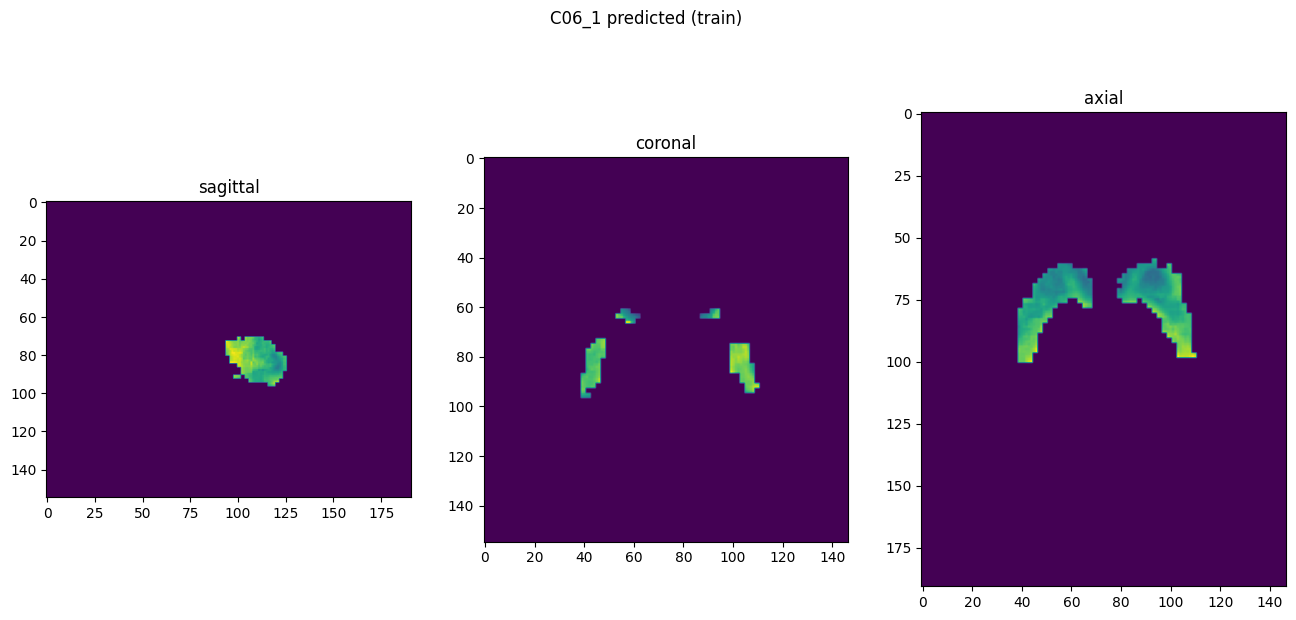

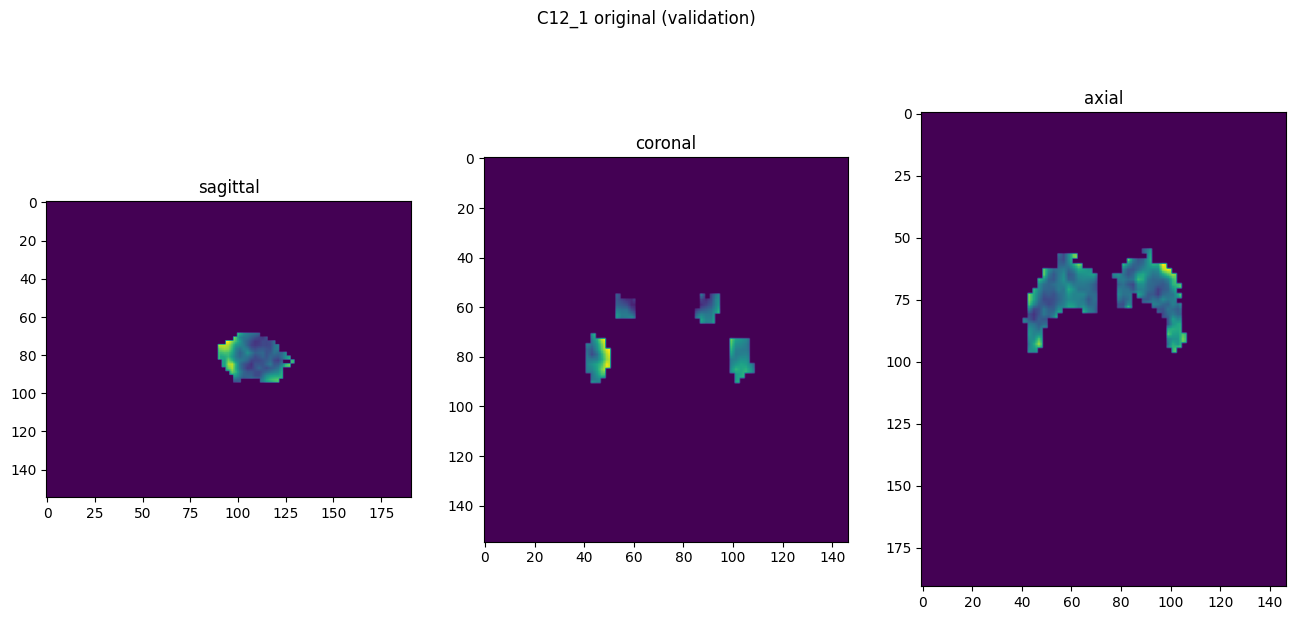

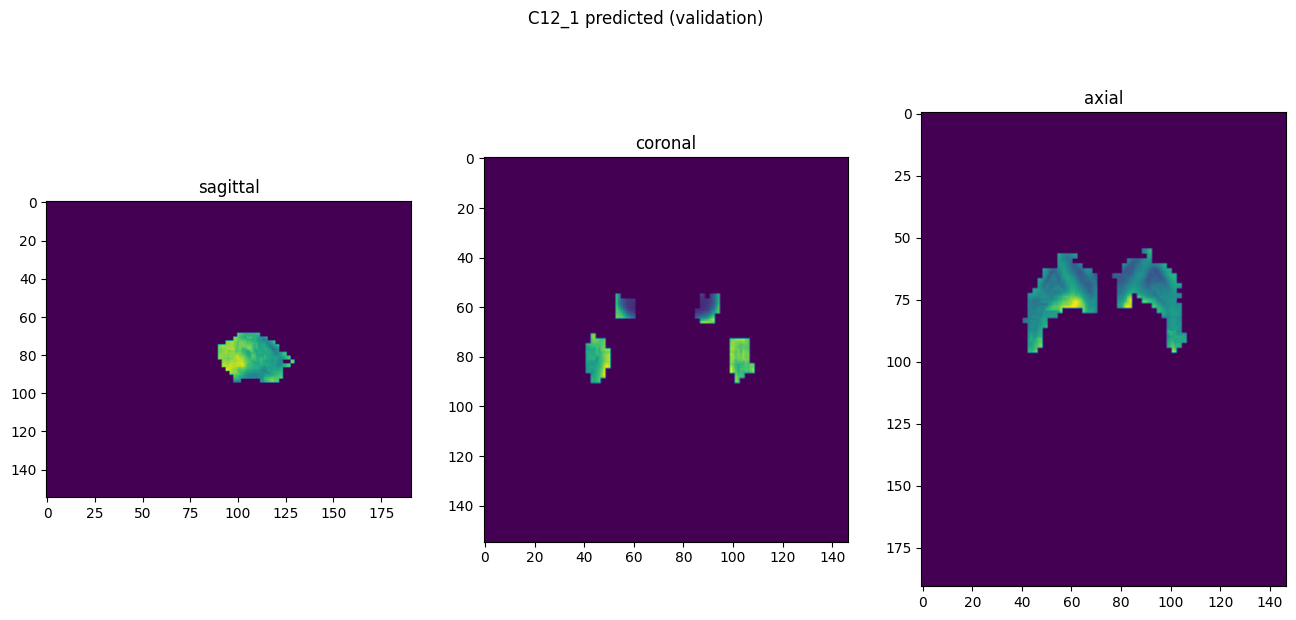

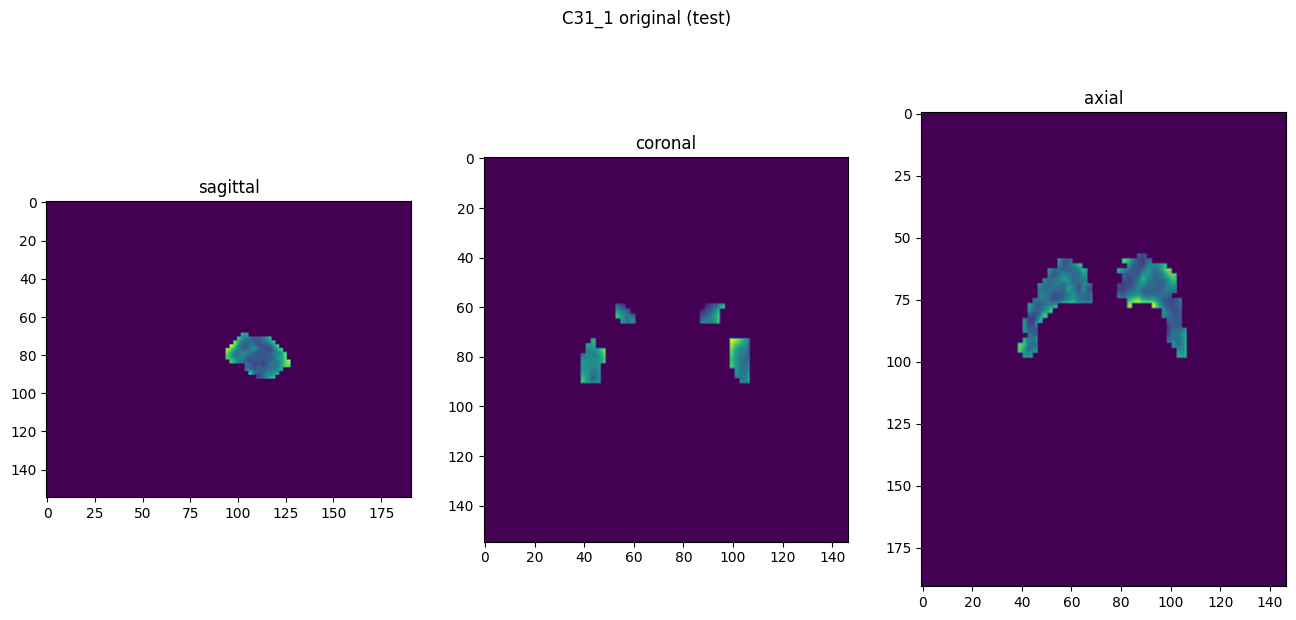

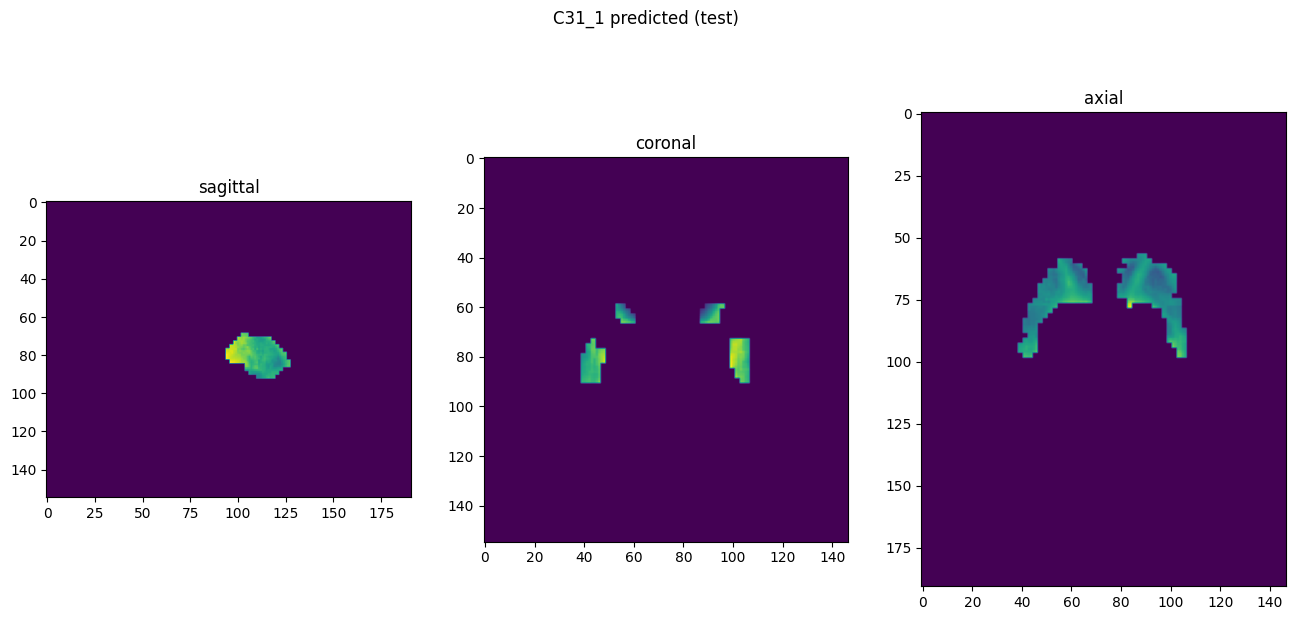

In [10]:
showResults(model, gen, threshold=None, background=False)